###Install Packages

In [1]:
!pip install yfinance

###Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline

###Latest S&P 500 Ticker List from Wikipedia

In [3]:
wiki_ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
for idx, symbol in enumerate(wiki_ticker_list['Symbol']):
  if symbol in ['BRK.B', 'BF.B']:
    wiki_ticker_list.loc[idx, 'Symbol'] = 'BRK-B' if symbol == 'BRK.B' else 'BF-B'
wiki_ticker_list.to_csv('sp500_tickers.csv')
wiki_ticker_list

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


###Download Data from Yahoo Finance
We use, ^IRX as the risk free rate (11 month T-bill yield)

In [4]:
sp500_data = yf.download(wiki_ticker_list['Symbol'].to_list() + ['^IRX'], start = '2003-09-30', end = '2023-09-30', auto_adjust = True)
sp500_data = sp500_data.swaplevel(axis = 1)
sp500_data.head()

[*********************100%%**********************]  504 of 504 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1064894400, endDate = 1696046400")


,VLTO,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,^IRX
,Adj Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-30 00:00:00,NaN,13.437274,NaN,0.314055,NaN,NaN,11.886887,3.674444,16.092520,19.663164,...,1461300,11822200,951400,NaN,2894671,2502694,832950,511300,NaN,0.0
2003-10-01 00:00:00,NaN,13.522356,NaN,0.315116,NaN,NaN,11.951137,3.713333,16.042095,19.867832,...,1355000,13500900,971200,NaN,5938179,1625546,429150,601700,NaN,0.0
2003-10-02 00:00:00,NaN,13.364346,NaN,0.311781,NaN,NaN,12.054504,3.716667,16.337435,19.802935,...,982700,8956800,1023000,NaN,3523959,1247330,332100,454700,NaN,0.0
2003-10-03 00:00:00,NaN,13.978168,NaN,0.328757,NaN,NaN,11.909236,3.715556,16.171759,20.401968,...,1510900,11383200,1933000,NaN,4017764,2290102,1138350,503900,NaN,0.0
2003-10-06 00:00:00,NaN,13.996401,NaN,0.337852,NaN,NaN,11.939965,3.744444,16.632780,20.486832,...,639600,7229000,783800,NaN,1974107,2374253,442200,305400,NaN,0.0


In [5]:
date_index = pd.Series(sp500_data.index)
sp500_data.index = date_index.apply(lambda x : x.to_pydatetime().date())

In [6]:
#Total number of stocks in the SP500 index

ticker_list = list(set(sp500_data.columns.get_level_values(0)))
ticker_list.remove('^IRX')
len(ticker_list)

503

###Principal Component Analysis

We use a subset of 50 stocks from the S&P 500 stock universe proportional to the relative weight of industries in the index.

In [7]:
import random as random

pca_ticker_list = ['MMM','ABT','ADBE','AES','AXP','AMGN','AAPL','T','AZO','BA','KO','CL','CMCSA','CVS','DIS','EIX','LLY','EFX','EQR','XOM','F','BEN','GD','GE','GS','HAL','HON','IBM','INTC','IP','INTU','TGT','MCD','MSFT','MS','NKE','NUE','PFE','PNW','PRU','PHM','QCOM','DGX','SPGI','SPG','UPS','VZ','VMC','WMT','WFC']

In [8]:
#calculating returns

price_df_500 = sp500_data.swaplevel(axis = 1).loc[:, 'Close']
volume_df_500 = sp500_data.swaplevel(axis = 1).loc[:, 'Volume']

returns_df_500 = price_df_500.copy()
returns_index = returns_df_500.index
returns_df_500.reset_index(drop = True, inplace = True)
returns_df_500 = (returns_df_500 / returns_df_500.shift(1)) - 1

In [9]:
#calculating excess return (relative to 11 month T-bill yield)

excess_returns_df_500 = returns_df_500.copy()

for asset in excess_returns_df_500.columns:
  excess_returns_df_500.loc[:, asset] = excess_returns_df_500.loc[:, asset] - (price_df_500.reset_index(drop = True).loc[:, '^IRX'] * 0.01 * (1/252))

risk_free_df = price_df_500.loc[:, '^IRX'] * 0.01
excess_returns_df_500.drop(columns = ['^IRX'], inplace = True)
price_df_500.drop(columns = ['^IRX'], inplace = True)
volume_df_500.drop(columns = ['^IRX'], inplace = True)

returns_df_500.set_index(returns_index, drop = True, inplace = True)
excess_returns_df_500.set_index(returns_index, drop = True, inplace = True)

####Cleaning Dataset for NaN values

In [10]:
#Number of tickers to be dropped due to missing data

temp_df = excess_returns_df_500.isna().sum(axis = 0)
nan_ticker_list = []
for ticker in temp_df.index:
  if temp_df.loc[ticker] > 8:
    nan_ticker_list.append(ticker)
print(f'No. of tickers with missing data = {len(nan_ticker_list)}')

No. of tickers with missing data = 112


In [11]:
returns_df_500.drop(columns = nan_ticker_list, axis = 1, inplace = True)
excess_returns_df_500.drop(columns = nan_ticker_list, axis = 1, inplace = True)

returns_df_500.dropna(axis = 0, inplace = True)
excess_returns_df_500.dropna(axis = 0, inplace = True)
risk_free_df = risk_free_df.loc[excess_returns_df_500.index]

In [12]:
temp_df = excess_returns_df_500.isna().sum(axis = 0)
counter = 0
for ticker in temp_df.index:
  if temp_df.loc[ticker] > 0:
    counter += 1
print(f'No. of tickers with missing data = {counter}')

No. of tickers with missing data = 0


####PCA date Range - (2003-10-01 to 2015-09-30)

In [13]:
price_df_500 = price_df_500.loc[excess_returns_df_500.index, excess_returns_df_500.columns]
price_df_500

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-10-01,13.522356,0.315116,11.951137,3.713333,16.042095,19.867832,25.018581,8.499082,18.267345,8.587076,...,52.918964,11.140153,10.213853,7.197237,19.455212,19.842655,7.933928,48.991337,34.919998,40.665657
2003-10-02,13.364346,0.311781,12.054504,3.716667,16.337435,19.802935,25.355989,8.607635,18.501980,8.641833,...,52.585079,11.113914,10.406048,7.331892,19.564600,19.855768,7.941527,49.413532,35.380001,40.686790
2003-10-03,13.978168,0.328757,11.909236,3.715556,16.171759,20.401968,26.737415,8.582090,18.836481,9.035097,...,52.852200,11.076435,10.433507,7.294748,19.663576,20.223072,7.870600,49.862095,36.566666,40.679741
2003-10-06,13.996401,0.337852,11.939965,3.744444,16.632780,20.486832,26.737415,8.594866,18.821493,9.119723,...,52.752033,11.072686,10.488426,7.341181,19.840675,20.139990,7.911131,50.873581,36.666668,41.200920
2003-10-07,14.239500,0.351947,11.789109,3.731111,16.654388,20.611629,27.361292,8.677876,19.190945,9.209329,...,53.002449,11.076435,10.455473,7.239027,19.970901,20.310518,7.997259,50.389839,36.666668,41.546017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,111.714767,176.080002,96.933411,81.150002,315.680695,511.600006,175.429993,77.300003,240.020004,205.669998,...,213.050903,31.350000,90.650002,59.490002,116.230003,34.029751,124.970001,117.095718,228.149994,34.580002
2023-09-26,110.507202,171.960007,95.700241,81.260002,309.327057,506.299988,172.339996,76.070000,237.240005,201.660004,...,212.393539,31.020000,90.680000,57.720001,116.410004,34.448029,124.010002,112.216316,223.960007,33.990002
2023-09-27,110.277657,170.429993,95.004089,81.080002,313.081512,502.600006,172.809998,76.360001,242.630005,202.279999,...,210.770004,31.030001,92.209999,57.209999,120.199997,33.970001,121.980003,110.519997,225.910004,33.169998


In [14]:
from datetime import datetime

pca_start_date, pca_end_date = datetime.strptime('2003-10-01', '%Y-%m-%d').date(), datetime.strptime('2015-09-30', '%Y-%m-%d').date()

returns_df_pca = returns_df_500.loc[pca_start_date : pca_end_date, pca_ticker_list]
excess_returns_df_pca = excess_returns_df_500.loc[pca_start_date : pca_end_date, pca_ticker_list]

#z-scoring excess returns
excess_returns_df_pca_z_scores = (excess_returns_df_pca - excess_returns_df_pca.mean(axis = 0))/(excess_returns_df_pca.std(axis = 0, ddof = 1))

###PCA

In [15]:
from sklearn.decomposition import PCA

pca_decomposition = PCA(n_components = None, svd_solver = 'full')
excess_returns_pca_full = pca_decomposition.fit_transform(excess_returns_df_pca_z_scores) #PCA on z-scores

In [16]:
cum_var = 0
for component, value in enumerate(pca_decomposition.explained_variance_ratio_):
  if component > 9:
    break
  cum_var += value
  print(f'Cummulative explained variance component {component + 1} = {cum_var * 100:.4f}%')

Cummulative explained variance component 1 = 45.8557%
Cummulative explained variance component 2 = 49.8076%
Cummulative explained variance component 3 = 52.5047%
Cummulative explained variance component 4 = 55.0389%
Cummulative explained variance component 5 = 57.0671%
Cummulative explained variance component 6 = 59.0076%
Cummulative explained variance component 7 = 60.7901%
Cummulative explained variance component 8 = 62.4875%
Cummulative explained variance component 9 = 64.0308%
Cummulative explained variance component 10 = 65.4810%


#### Percentage Variance explained by each PC

Text(0.5, 1.0, 'Explained Variance Ratio for PCs')

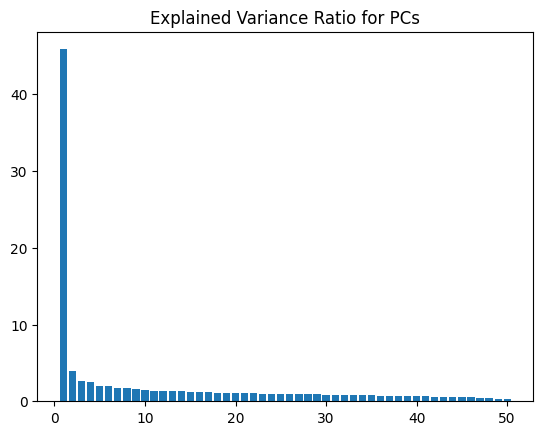

In [17]:
plt.bar(range(1, 51), pca_decomposition.explained_variance_ratio_ * 100)
plt.title('Explained Variance Ratio for PCs')

###We decide to use the first 5 principal components as the factors for our stochastic factor model

In [18]:
pca_components = 5
pca_decomposition_5 = PCA(n_components = 5, svd_solver = 'full')

#pca transformed returns a.k.a stochastic factors
excess_returns_pca_5 = pca_decomposition_5.fit_transform(excess_returns_df_pca_z_scores) #PCA-5 on z-scores

###Principal Component TS

In [19]:
col_names = ['PC ' + str(idx + 1) for idx in range(pca_components)]
excess_returns_pca_5_df = pd.DataFrame(excess_returns_pca_5, index = excess_returns_df_pca_z_scores.index, columns = col_names)

#z-scoring the stochastic factors
excess_returns_pca_5_df_z_scores = (excess_returns_pca_5_df - excess_returns_pca_5_df.mean(axis = 0)) / excess_returns_pca_5_df.std(axis = 0, ddof = 1)
excess_returns_pca_5_df_z_scores

,PC 1,PC 2,PC 3,PC 4,PC 5
Date,,,,,
2003-10-01,1.791766,-1.776547,-1.057393,-0.405728,-0.331401
2003-10-02,0.121262,-0.262009,-0.340851,1.075051,-0.048204
2003-10-03,0.734920,0.505727,1.348044,-2.430192,-0.187887
2003-10-06,0.103640,0.156769,-0.450813,-0.311582,0.233171
2003-10-07,0.419518,-0.264239,0.002790,-2.147133,-1.253436
...,...,...,...,...,...
2015-09-24,-0.331138,-0.435837,0.021183,0.105093,-0.355950
2015-09-25,0.211863,0.903642,-0.195497,-0.629776,-1.790635
2015-09-28,-1.905975,1.242997,0.959026,-0.298443,-0.105501


####Splitting excess returns into in-sample data and out-of-sample data

In [20]:
excess_returns_df_500_LR = excess_returns_df_500.loc[pca_start_date:pca_end_date, :]

#z-scoring returns
excess_returns_df_500_LR_z_scores = (excess_returns_df_500_LR - excess_returns_df_500_LR.mean(axis = 0))/ excess_returns_df_500_LR.std(axis = 0, ddof = 1)

###Linear Regression

We perform a linear regression for each stock v/s the stochastic factors to calculate the factor loadings i.e. betas.

In [21]:
from sklearn.linear_model import LinearRegression

regression_coef = []
linear_model = LinearRegression(fit_intercept=True)

X = excess_returns_pca_5_df_z_scores

for idx, ticker in enumerate(excess_returns_df_500_LR_z_scores.columns):
  y = excess_returns_df_500_LR_z_scores.loc[:, ticker]
  linear_model.fit(X,y)
  beta = list(linear_model.coef_)
  alpha = linear_model.intercept_
  regression_coef.append([alpha] + beta)

###Factor Loadings for Stocks

In [22]:
factor_model_df = pd.DataFrame(regression_coef, index = excess_returns_df_500_LR_z_scores.columns, columns = ['alpha', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5'])
beta_df = factor_model_df.drop(columns = ['alpha'], axis = 1)
factor_model_df

,alpha,beta_1,beta_2,beta_3,beta_4,beta_5
A,-1.275156e-17,0.690177,-0.026421,0.138317,-0.106531,0.012417
AAPL,5.119837e-20,0.536326,0.058034,0.110279,-0.384312,0.083242
ABT,-8.586226e-18,0.557009,-0.352298,-0.220573,0.190966,0.150916
ACGL,1.207385e-17,0.626719,0.063161,-0.041434,0.111402,0.012358
ACN,-3.281982e-18,0.588556,-0.034910,0.071304,-0.085491,0.052884
...,...,...,...,...,...,...
XRAY,-6.084932e-18,0.665822,-0.068300,0.020666,-0.005851,0.020340
YUM,-1.973181e-18,0.653465,-0.021042,-0.078195,-0.090781,-0.105740
ZBH,9.190359e-18,0.568737,-0.059356,0.018730,0.027850,0.020248
ZBRA,-6.727958e-18,0.568652,0.019872,0.099294,-0.090227,-0.035424


In [23]:
num_assets_in_portfolio = len(factor_model_df)
tickers_in_portfolio = excess_returns_df_500_LR_z_scores.columns

#Initialize weights
weights = np.array([(1.0/num_assets_in_portfolio) for i in range(num_assets_in_portfolio)])
#weights = np.random.uniform(-1, 1, size = num_assets_in_portfolio)
print(f'No. of stocks in portfolio = {num_assets_in_portfolio}')

No. of stocks in portfolio = 391


In [24]:
#calculate net portfolio beta
def portfolio_beta(weights, beta_df):
  weighted_portfolio_beta = np.multiply(weights.reshape(-1, 1), beta_df)
  net_portfolio_beta = weighted_portfolio_beta.sum(axis = 1).sum()
  return net_portfolio_beta

#beta squared
def portfolio_beta_sq(weights, beta_df):
  return portfolio_beta(weights, beta_df) ** 2

#contraints
constraints = ({'type' : 'eq', 'fun' : lambda x : x.sum()})

###Optimization

We minimize the square of the portfolio beta using an limited-memory BFGS optimization algorithm to calculate the beta neutral weights for the in-sample portfolio

In [25]:
from scipy.optimize import minimize

sol = minimize(portfolio_beta_sq, weights, args = (beta_df), constraints=constraints)
if sol.success:
  print(f'Solution Found, optimizer message = {sol.message}')
  beta_neutral_weights = sol.x
  print(f'Portfolio Beta = {portfolio_beta(beta_neutral_weights, beta_df)}')
else:
  print(f'Solution not found, optimizer message = {sol.message}')

Solution Found, optimizer message = Optimization terminated successfully
Portfolio Beta = -3.687377286021319e-05


###Beta Neutral Weights

In [27]:
long_positions = short_positions = 0
for weight in beta_neutral_weights:
  if weight > 0:
    long_positions += 1
  elif weight < 0:
    short_positions += 1
print(f'No. of long positions = {long_positions}')
print(f'No. of short positions = {short_positions}')
print(f'Total positions = {long_positions + short_positions}')
print(f'Total stocks = {num_assets_in_portfolio}')

No. of long positions = 214
No. of short positions = 177
Total positions = 391
Total stocks = 391


###Beta-Neutral Portfolio Factor Exposures (aggregate)

In [28]:
beta_neutral_portfolio_factor_exposure = np.multiply(beta_neutral_weights.reshape(-1, 1), factor_model_df).sum(axis = 0)
beta_neutral_portfolio_factor_exposure

alpha    -1.458074e-22
beta_1   -8.040575e-06
beta_2   -1.417917e-05
beta_3   -5.161165e-06
beta_4   -6.371042e-06
beta_5   -3.121821e-06
dtype: float64

In [29]:
weighted_returns = beta_neutral_weights.reshape(1, -1) * excess_returns_df_500_LR_z_scores
bn_port_returns = weighted_returns.sum(axis = 1)
bn_port_returns

Date
2003-10-01    1.633610e-05
2003-10-02    5.916767e-06
2003-10-03    5.462386e-06
2003-10-06    7.083045e-07
2003-10-07    6.289875e-06
                  ...     
2015-09-24    7.119886e-06
2015-09-25   -1.703483e-05
2015-09-28   -1.940342e-05
2015-09-29   -9.794462e-06
2015-09-30    1.233218e-05
Length: 3016, dtype: float64

####Beta Neutral Portfolio Factor Exposures (Regression)

In [30]:
y = bn_port_returns
X = excess_returns_pca_5_df_z_scores
linear_model.fit(X, y)
print(f'alpha = {linear_model.intercept_}')
print(f'betas = {linear_model.coef_}')

alpha = -3.142427648669667e-22
betas = [-8.04057470e-06 -1.41791703e-05 -5.16116487e-06 -6.37104188e-06
 -3.12182114e-06]


###Out of Sample Analysis

In [31]:
#Out of sample data
out_of_sample_returns = excess_returns_df_500.loc[pca_end_date:,:]
out_of_sample_returns = out_of_sample_returns.iloc[1:, :]
#z-scoring using in-sample mean and standard deviation
insample_mean, insample_std = excess_returns_df_500_LR.mean(axis = 0), excess_returns_df_500_LR.std(axis = 0, ddof = 1)

#z-scoring out of sample returns
out_of_sample_returns_z_scores = (out_of_sample_returns - insample_mean)/insample_std

###Calculating out of sample factors

In [32]:
#pca transform for out of sample returns

out_of_sample_factors = pca_decomposition_5.transform(out_of_sample_returns_z_scores.loc[:, pca_ticker_list])

col_names = ['PC ' + str(idx + 1) for idx in range(pca_components)]
oos_factor_df = pd.DataFrame(out_of_sample_factors, index = out_of_sample_returns_z_scores.index, columns = col_names)
oos_factor_df_z_scores = (oos_factor_df - oos_factor_df.mean(axis = 0))/oos_factor_df.std(axis = 0, ddof = 1)

### Out of sample factor loadings i.e. betas

In [33]:
regression_coef = []
linear_model = LinearRegression(fit_intercept=True)

X = oos_factor_df_z_scores

for idx, ticker in enumerate(out_of_sample_returns_z_scores.columns):
  y = out_of_sample_returns_z_scores.loc[:, ticker]
  linear_model.fit(X,y)
  beta = list(linear_model.coef_)
  alpha = linear_model.intercept_
  regression_coef.append([alpha] + beta)

In [34]:
oos_factor_model_df = pd.DataFrame(regression_coef, index = out_of_sample_returns_z_scores.columns, columns = ['alpha', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5'])
beta_df = factor_model_df.drop(columns = ['alpha'], axis = 1)
oos_factor_model_df

,alpha,beta_1,beta_2,beta_3,beta_4,beta_5
A,0.011574,0.495523,-0.068835,0.002097,-0.092225,0.106609
AAPL,-0.026616,0.432990,-0.108423,0.080872,-0.342044,0.097605
ABT,0.016399,0.763870,-0.284063,-0.192991,0.036582,0.321782
ACGL,0.001591,0.967031,0.124224,-0.037518,0.234261,-0.050454
ACN,0.003164,0.688060,-0.045660,0.004637,-0.163185,0.059639
...,...,...,...,...,...,...
XRAY,-0.024709,0.787638,0.132595,-0.032485,0.130157,-0.014757
YUM,-0.011722,0.551015,-0.004079,-0.028259,-0.049112,-0.108748
ZBH,-0.002865,0.660503,0.046175,0.043137,0.074485,0.007839
ZBRA,0.021816,0.724447,0.102744,0.038047,-0.246357,0.090463


###Out of sample beta-neutral portfolio exposure (aggregate)

In [35]:
oos_portfolio_beta_exposure = np.multiply(beta_neutral_weights.reshape(-1, 1), oos_factor_model_df).sum(axis = 0)
oos_portfolio_beta_exposure

alpha    -2.924979e-07
beta_1   -6.899758e-06
beta_2   -1.385714e-05
beta_3   -7.823354e-06
beta_4   -7.865672e-06
beta_5   -3.746880e-06
dtype: float64

In [36]:
weighted_out_of_sample_returns = beta_neutral_weights.reshape(1, -1) * out_of_sample_returns
weighted_oos_port_returns = weighted_out_of_sample_returns.sum(axis = 1)
weighted_oos_port_returns

Date
2015-10-01    3.439922e-08
2015-10-02    1.718992e-07
2015-10-05   -6.930853e-07
2015-10-06   -9.315210e-07
2015-10-07   -2.889512e-07
                  ...     
2023-09-25   -2.447064e-07
2023-09-26    2.088985e-07
2023-09-27   -4.329239e-07
2023-09-28   -2.266975e-07
2023-09-29    2.041804e-07
Length: 2011, dtype: float64

In [37]:
weighted_oos_port_returns_z_scores = (weighted_oos_port_returns - weighted_oos_port_returns.mean(axis = 0)) / weighted_oos_port_returns.std(axis = 0, ddof = 1)

###Out of sample beta-neutral portfolio factor exposure (regression)

In [38]:
X = oos_factor_df
y = weighted_oos_port_returns_z_scores
linear_model.fit(X, y)
print(f'Alpha : {linear_model.intercept_}')
print(f'Betas : {linear_model.coef_}')

Alpha : -0.014408413485386221
Betas : [-0.15757356 -0.42769476 -0.21340352 -0.32521557 -0.11655734]


### Simulator

In [39]:
from sklearn.decomposition import PCA
from scipy.optimize import minimize

class SimulateStrategy(object):

  def __init__(self, beta_neutral_weights, price_df, returns_df, excess_returns_df):
    self.beta_neutral_wts = beta_neutral_weights
    self.price_df = price_df
    self.returns_df = returns_df
    self.excess_returns_df = excess_returns_df
    self.dates = excess_returns_df.index.to_series().reset_index(drop = True)
    self.pca_start_date, self.pca_end_date = pca_start_date, pca_end_date

    self.pca_excess_returns_df = self.excess_returns_df.loc[pca_start_date: pca_end_date, pca_ticker_list]
    self.pca_window_len = len(self.pca_excess_returns_df)

    self.linear_model = LinearRegression(fit_intercept = True, n_jobs=-1)

  def _return_z_score(self, df):
    mean, std = df.mean(axis = 0), df.std(axis = 0, ddof = 1)
    return (df - mean) / std

  def _calc_portfolio_beta(self, weights):
    weighted_portfolio_beta = np.multiply(weights.reshape(-1, 1), self.betas)
    net_portfolio_beta = weighted_portfolio_beta.sum(axis = 1).sum()
    return net_portfolio_beta

  def _calc_portfolio_beta_sq(self, weights):
    return self._calc_portfolio_beta(weights) ** 2

  def _calc_portfolio_value(self, prices):
    portfolio_value = np.multiply(self.beta_neutral_wts, prices).sum()
    return portfolio_value

  def _recalibrate_betas(self, start_date, end_date):
    self.pca_excess_returns_df = self.excess_returns_df.loc[start_date:end_date, pca_ticker_list]
    self.pca_excess_returns_df_z_scores = self._return_z_score(self.pca_excess_returns_df)

    self.pca_5 = PCA(n_components=5, svd_solver = 'full')

    self.principal_comps = self.pca_5.fit_transform(self.pca_excess_returns_df_z_scores)
    self.principal_comps_z_scores = self._return_z_score(self.principal_comps)
    self.excess_returns_df_LR = self.excess_returns_df.loc[start_date:end_date, :]
    self.excess_returns_df_LR_z_scores = self._return_z_score(self.excess_returns_df_LR)

    self.regression_coef = []
    X = self.principal_comps_z_scores
    for idx, ticker in enumerate(self.excess_returns_df_LR_z_scores):
      y = self.excess_returns_df_LR_z_scores.loc[:, ticker]
      self.linear_model.fit(X, y)
      beta = list(self.linear_model.coef_)
      alpha = self.linear_model.intercept_
      self.regression_coef.append([alpha] + beta)

    self.factor_df = pd.DataFrame(self.regression_coef, index = self.excess_returns_df_LR_z_scores.columns, columns = ['alpha', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'beta_5'])
    self.betas = self.factor_df.drop(columns = ['alpha'], axis = 1)

  def _calc_beta_neutral_weights(self):
    constraints = ({'type' : 'eq', 'fun' : lambda x : x.sum()})
    solver = minimize(self._calc_portfolio_beta_sq, self.beta_neutral_wts, constraints=constraints)
    if solver.success:
      self.beta_neutral_wts = solver.x
    else:
      raise RuntimeError(f'Solver failed to converge : {solver.message}')

  def _rebalance_portfolio(self, prices):
    self.trade_quantities = self.beta_neutral_wts - self.previous_weights
    self.trade_values = np.multiply(self.trade_quantities, prices)
    self.cumm_trade_val = self.trade_values.sum()

  def _calculate_portfolio_pnl(self):
    self.pnl = self.curr_portfolio_val - self.prev_portfolio_val

  def simulate(self):
    self.pca_start_index, self.pca_end_index = self.dates[self.dates == self.pca_start_date].index, self.dates[self.dates == self.pca_end_date].index
    self.prev_portfolio_val, self.curr_portfolio_val = 0, self._calc_portfolio_value(self.price_df.loc[self.pca_end_date, :])
    self.portfolio_values, self.portfolio_weights = [], []
    self.sim_date_index = self.pca_end_index + 1
    self.sim_date = self.dates.iloc[self.sim_date_index].values[-1]
    self.current_month = self.sim_date.month

    while(self.sim_date_index + 1 < len(self.dates)):
      self.sim_date_index += 1
      self.sim_date = self.dates.iloc[self.sim_date_index].values[-1]
      self.current_prices = self.price_df.loc[self.sim_date, :]
      self.prev_portfolio_val = self.curr_portfolio_val

      if self.sim_date.month != self.current_month:
        self.current_month = self.sim_date.month
        self.pca_end_date, self.pca_start_date = self.dates.iloc[self.sim_date_index - 1].values[-1], self.dates.iloc[self.sim_date_index - self.pca_window_len].values[-1]
        self.previous_weights = self.beta_neutral_wts

        self._recalibrate_betas(self.pca_start_date, self.pca_end_date)
        self._calc_beta_neutral_weights()

      self.curr_portfolio_val = self._calc_portfolio_value(self.current_prices)
      self.portfolio_values.append((self.sim_date, self.curr_portfolio_val))
      self.portfolio_weights.append((self.sim_date, self.beta_neutral_wts))

    self.portfolio_values_df = pd.DataFrame(self.portfolio_values, columns = ['Date', 'Portfolio Value']).set_index('Date', drop = True)
    self.portfolio_weights_df = pd.DataFrame(self.portfolio_weights, columns = ['Date', 'Portfolio Weights']).set_index('Date', drop = True)
    self.portfolio_returns_df = (self.portfolio_values_df/self.portfolio_values_df.shift(1)) - 1
    self.portfolio_returns_df.rename(columns = {'Portfolio Value' : 'Portfolio Return'}, inplace = True)

    print('Simulation Completed')


#Backtesting

In [40]:
simulator = SimulateStrategy(beta_neutral_weights, price_df_500, returns_df_500, excess_returns_df_500)

try:
  simulator.simulate()

except RuntimeError as exp:
  print(exp)

Simulation Completed


In [41]:
strategy_returns = simulator.portfolio_returns_df
risk_free_df = risk_free_df.loc[strategy_returns.index]
strategy_excess_returns = strategy_returns['Portfolio Return'] - risk_free_df

In [42]:
strategy_sharpe_ratio = strategy_excess_returns.mean() / strategy_excess_returns.std(ddof = 1)
strategy_sortino_ratio = strategy_excess_returns.mean() / strategy_excess_returns.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)

print(f'Strategy Sharpe Ratio = {strategy_sharpe_ratio:.4f}')
print(f'Strategy Sortino Ratio = {strategy_sortino_ratio:.4f}')

Strategy Sharpe Ratio = -0.6794
Strategy Sortino Ratio = -0.7950


In [43]:
benchmark_sp500 = yf.download('SPY', start = '2003-09-30', end = '2023-09-30', auto_adjust = True)['Close']
benchmark_sp500 = benchmark_sp500.reindex(benchmark_sp500.index.to_series().apply(lambda x : x.to_pydatetime().date()))
benchmark_sp500_returns = (benchmark_sp500 / benchmark_sp500.shift(1)) - 1

benchmark = benchmark_sp500_returns.loc[strategy_returns.index]
benchmark_excess_returns = benchmark - risk_free_df

benchmark_sharpe_ratio = benchmark_excess_returns.mean() / benchmark_excess_returns.std(ddof = 1)
benchmark_sortino_ratio = benchmark_excess_returns.mean() / benchmark_excess_returns.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)

print(f'Benchmark Sharpe Ratio = {benchmark_sharpe_ratio:.4f}')
print(f'Benchmark Sortino Ratio = {benchmark_sortino_ratio:.4f}')

[*********************100%%**********************]  1 of 1 completed
Benchmark Sharpe Ratio = -0.7093
Benchmark Sortino Ratio = -0.8119


In [44]:
strategy_vs_benchmark = strategy_returns['Portfolio Return'] - benchmark

strategy_vs_benchmark_sharpe_ratio = strategy_vs_benchmark.mean() / strategy_vs_benchmark.std(ddof = 1)
strategy_vs_benchmark_sortino_ratio = strategy_vs_benchmark.mean() / strategy_vs_benchmark.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)

print(f'Strategy v/s Benchmark Sharpe Ratio = {strategy_vs_benchmark_sharpe_ratio:.4f}')
print(f'Strategy v/s Benchmark Sortino Ratio = {strategy_vs_benchmark_sortino_ratio:.4f}')

Strategy v/s Benchmark Sharpe Ratio = 0.0141
Strategy v/s Benchmark Sortino Ratio = 0.0231


(-10.0, 10.0)

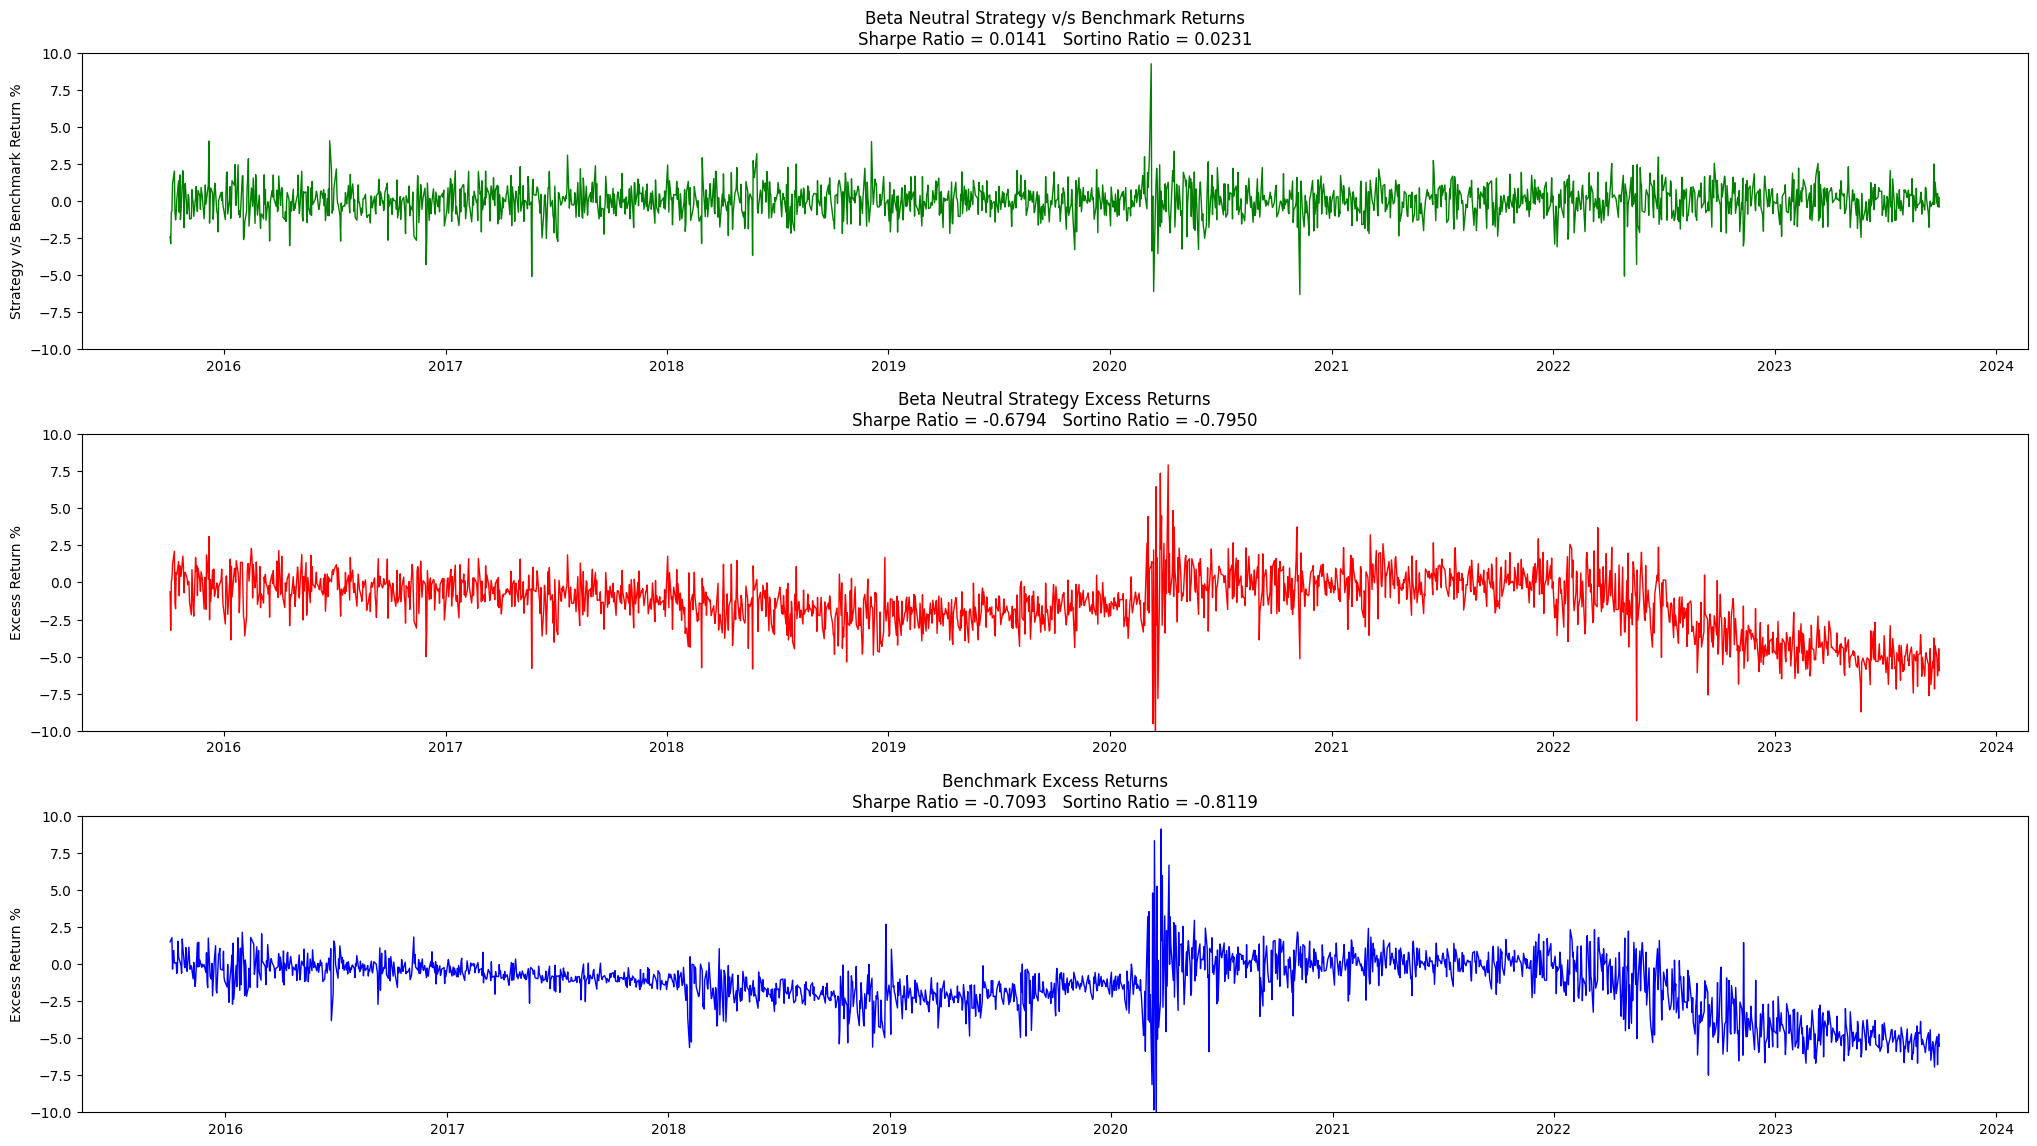

In [45]:
fig, axs = plt.subplots(3, figsize = (21, 12))
plt.rc('xtick', labelsize=9)
fig.tight_layout(pad = 4.0)
axs[0].plot(strategy_vs_benchmark * 100, label = 'Strategy v/s Benchmark Daily Returns', color = 'green', linewidth = 1)
axs[0].set_ylabel('Strategy v/s Benchmark Return %')
axs[0].set_title(f'Beta Neutral Strategy v/s Benchmark Returns\nSharpe Ratio = {strategy_vs_benchmark_sharpe_ratio:.4f}   Sortino Ratio = {strategy_vs_benchmark_sortino_ratio:.4f}', fontsize = 12)
axs[0].set_ylim(-10,10)
axs[1].plot(strategy_excess_returns * 100, label = 'Strategy Excess Daily Returns', color = 'red', linewidth = 1)
axs[1].set_ylabel('Excess Return %')
axs[1].set_title(f'Beta Neutral Strategy Excess Returns\nSharpe Ratio = {strategy_sharpe_ratio:.4f}   Sortino Ratio = {strategy_sortino_ratio:.4f}', fontsize = 12)
axs[1].set_ylim(-10,10)
axs[2].plot(benchmark_excess_returns * 100, label = 'Benchmark Excess Daily Returns', color = 'blue', linewidth = 1)
axs[2].set_title(f'Benchmark Excess Returns\nSharpe Ratio = {benchmark_sharpe_ratio:.4f}   Sortino Ratio = {benchmark_sortino_ratio:.4f}', fontsize = 12)
axs[2].set_ylabel('Excess Return %')
axs[2].set_ylim(-10,10)